# Imports

In [1]:
# Import standard libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# API
import requests
import json
import os
from sodapy import Socrata

# Datetime
import datetime as datetime

## API Call: NYC Parking Tickets

In [2]:
# Export sodapy token

socrata_domain = 'data.cityofnewyork.us'
socrata_dataset_identifier = 'nc67-uf89'
socrata_token = os.environ.get("SODAPY_APPTOKEN")

# Make request

client = Socrata(socrata_domain, socrata_token)
print("Domain: {domain:}\nSession: {session:}\nURI Prefix: {uri_prefix:}")

Domain: {domain:}
Session: {session:}
URI Prefix: {uri_prefix:}


In [3]:
# Identify all columns available in dataset

metadata = client.get_metadata(socrata_dataset_identifier)
[x['name'] for x in metadata['columns']]

['Plate',
 'State',
 'License Type',
 'Summons Number',
 'Issue Date',
 'Violation Time',
 'Violation',
 'Judgment Entry Date',
 'Fine Amount',
 'Penalty Amount',
 'Interest Amount',
 'Reduction Amount',
 'Payment Amount',
 'Amount Due',
 'Precinct',
 'County',
 'Issuing Agency',
 'Violation Status',
 'Summons Image']

In [5]:
# Pull API. Limit number is based on previously identified as the number of street parking violations from the total 50m rows of data

results = client.get(socrata_dataset_identifier,\
                     select=('Plate, State,Issue_Date,Violation_Time,Fine_Amount,Amount_Due,Payment_Amount,\
                     Precinct,County'),\
                     where ="(violation='NO PARKING-STREET CLEANING')",\
                     limit=7000000)

results_df = pd.DataFrame.from_dict(results)
results_df.head()

,Plate,State,Issue_Date,Violation_Time,Fine_Amount,Amount_Due,Payment_Amount,Precinct,County
0,YAU84L,FL,07/05/2088,11:05A,20,170.79,0,109,Q
1,6E35C,NY,03/17/2020,01:34P,65,65,0,060,K
2,EJLX5,NY,03/17/2020,01:30P,65,65,0,060,K
3,N49JLG,NJ,03/17/2020,01:22P,65,65,0,060,K
4,JPG3319,NY,03/17/2020,01:14P,65,65,0,060,K


In [7]:
# Confirm that this number is less than 7M

results_df.shape

(6791294, 9)

# Data Analysis

In [8]:
# Create a copy of the dataframe to preserve the content of the API export during cleaning

violation_df = results_df.copy()
violation_df.head()

,Plate,State,Issue_Date,Violation_Time,Fine_Amount,Amount_Due,Payment_Amount,Precinct,County
0,YAU84L,FL,07/05/2088,11:05A,20,170.79,0,109,Q
1,6E35C,NY,03/17/2020,01:34P,65,65,0,060,K
2,EJLX5,NY,03/17/2020,01:30P,65,65,0,060,K
3,N49JLG,NJ,03/17/2020,01:22P,65,65,0,060,K
4,JPG3319,NY,03/17/2020,01:14P,65,65,0,060,K


In [9]:
# Combine object fields for a correct timestamp

violation_df['time_issued'] = (violation_df['Issue_Date'] + ' ' + violation_df['Violation_Time'])
violation_df.head()

,Plate,State,Issue_Date,Violation_Time,Fine_Amount,Amount_Due,Payment_Amount,Precinct,County,time_issued
0,YAU84L,FL,07/05/2088,11:05A,20,170.79,0,109,Q,07/05/2088 11:05A
1,6E35C,NY,03/17/2020,01:34P,65,65,0,060,K,03/17/2020 01:34P
2,EJLX5,NY,03/17/2020,01:30P,65,65,0,060,K,03/17/2020 01:30P
3,N49JLG,NJ,03/17/2020,01:22P,65,65,0,060,K,03/17/2020 01:22P
4,JPG3319,NY,03/17/2020,01:14P,65,65,0,060,K,03/17/2020 01:14P


In [10]:
# Convert object field to datetime

violation_df['time_issued']=pd.to_datetime(violation_df['time_issued'], errors='coerce')
violation_df.head(10)

,Plate,State,Issue_Date,Violation_Time,Fine_Amount,Amount_Due,Payment_Amount,Precinct,County,time_issued
0,YAU84L,FL,07/05/2088,11:05A,20,170.79,0,109,Q,2088-07-05 11:05:00
1,6E35C,NY,03/17/2020,01:34P,65,65,0,060,K,2020-03-17 13:34:00
2,EJLX5,NY,03/17/2020,01:30P,65,65,0,060,K,2020-03-17 13:30:00
3,N49JLG,NJ,03/17/2020,01:22P,65,65,0,060,K,2020-03-17 13:22:00
4,JPG3319,NY,03/17/2020,01:14P,65,65,0,060,K,2020-03-17 13:14:00
5,KZY0893,PA,03/17/2020,09:00A,65,65,0,052,BX,2020-03-17 09:00:00
6,HWT9062,NY,03/17/2020,08:45A,65,65,0,046,BX,2020-03-17 08:45:00
7,JMK4979,NY,03/17/2020,08:42A,65,65,0,046,BX,2020-03-17 08:42:00
8,T934673,NJ,03/17/2020,08:40A,65,65,0,046,BX,2020-03-17 08:40:00
9,LHH6171,PA,03/17/2020,08:17A,65,65,0,052,BX,2020-03-17 08:17:00


In [11]:
# Drop columns with incorrect datetime

violation_df.drop(['Violation_Time', 'Issue_Date'], axis=1, inplace=True)
violation_df.loc[violation_df['time_issued']=='NaT', 'time_issued']= np.nan 
violation_df.dropna(inplace = True)

In [12]:
# Convert object fields to float

violation_df['Precinct'] = violation_df['Precinct'].astype(float)
violation_df['Fine_Amount'] = violation_df['Fine_Amount'].astype(float)
violation_df['Amount_Due'] = violation_df['Amount_Due'].astype(float)
violation_df['Payment_Amount'] = violation_df['Amount_Due'].astype(float)

In [13]:
# Remove precint placeholder numbers

violation_df.loc[violation_df['Precinct']>123, 'Precinct']= np.nan 
violation_df.dropna(inplace = True)

In [14]:
violation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6767435 entries, 0 to 6791292
Data columns (total 8 columns):
 #   Column          Dtype         
---  ------          -----         
 0   Plate           object        
 1   State           object        
 2   Fine_Amount     float64       
 3   Amount_Due      float64       
 4   Payment_Amount  float64       
 5   Precinct        float64       
 6   County          object        
 7   time_issued     datetime64[ns]
dtypes: datetime64[ns](1), float64(4), object(3)
memory usage: 464.7+ MB


In [15]:
#Define the timeframe of the analysis to be within two calendar years. Data collection began mid-2016.

violation_df.loc[violation_df['time_issued']>'2019-12-31 12:00:00', 'time_issued']= np.nan
violation_df.loc[violation_df['time_issued']<'2017-01-01 12:00:00', 'time_issued']= np.nan
violation_df.dropna(inplace = True)

In [16]:
#Confirm that the timeframe is correct

min(violation_df['time_issued'])

Timestamp('2017-01-02 00:00:00')

In [17]:
#Confirm that the timeframe is correct

max(violation_df['time_issued'])

Timestamp('2019-12-31 12:00:00')

In [18]:
# Rearrange columns for easier data visualization

violation_df = violation_df[[ 'Plate','time_issued', 'Fine_Amount', 'Amount_Due', 'Payment_Amount',
       'Precinct', 'County', 'State']]
violation_df.head()

,Plate,time_issued,Fine_Amount,Amount_Due,Payment_Amount,Precinct,County,State
9668,KYM0585,2019-12-31 10:26:00,45.0,75.0,75.0,63.0,K,PA
9669,3247071,2019-12-31 10:22:00,45.0,55.0,55.0,63.0,K,PA
9670,2FWQ91,2019-12-31 10:15:00,45.0,55.0,55.0,63.0,K,MI
9671,JDP9488,2019-12-31 10:05:00,45.0,75.0,75.0,63.0,K,NY
9672,5TM825,2019-12-31 09:59:00,45.0,75.0,75.0,63.0,K,MA


In [19]:
# Create dummy variables

violation_df['weekday'] = violation_df['time_issued'].dt.weekday
county_dummies = pd.get_dummies(violation_df['County'], prefix='County')
weekday_dummies = pd.get_dummies(violation_df['weekday'], prefix='weekday')
violation_df = pd.concat([violation_df, county_dummies, weekday_dummies], axis=1)
violation_df.drop(columns =['County','weekday'], inplace=True)
violation_df.columns

Index(['Plate', 'time_issued', 'Fine_Amount', 'Amount_Due', 'Payment_Amount',
       'Precinct', 'State', 'County_BX', 'County_K', 'County_NY', 'County_Q',
       'County_R', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6'],
      dtype='object')

In [20]:
# Rename counties to be more recognizable

violation_df.rename(columns={'County_BX':'Bronx', 'County_K':'Brooklyn', \
                             'County_NY':'Manhattan', 'County_Q':'Queens', \
                             'County_R':'Staten_Island'}, inplace=True)

In [21]:
# Make state plates a binary

violation_df.loc[violation_df['State'] =='NY', 'State']= 1

out_of_state = {'FL':0, 'NJ':0, 'MI':0, 'RI':0, 'PA':0, 'VA':0, 'ME':0, 'CT':0, 'NC':0, 'AL':0,
       'TX':0, 'IL':0, 'MA':0, 'WI':0, 'IN':0, 'GV':0, 'NH':0, 'OH':0, '99':0, 'AZ':0, 'CA':0,
       'SC':0, 'LA':0, 'GA':0, 'VT':0, 'OR':0, 'MD':0, 'SD':0, 'MO':0, 'DE':0, 'WV':0, 'OK':0,
       'ON':0, 'CO':0, 'AR':0, 'AK':0, 'QB':0, 'WA':0, 'MT':0, 'NV':0, 'UT':0, 'TN':0, 'DC':0, 'YT':0,
       'NE':0, 'KY':0, 'IA':0, 'MN':0, 'ID':0, 'KS':0, 'ND':0, 'MS':0, 'NM':0, 'WY':0, 'HI':0, 'NF':0,
       'MX':0, 'DP':0, 'AB':0, 'NS':0, 'BC':0, 'PR':0, 'NB':0, 'FO':0, 'MB':0, 'PE':0, 'SK':0, 'NT':0}

violation_df['State'].replace(out_of_state, inplace = True)
violation_df['State'].value_counts()

1    3809378
0    1203324
Name: State, dtype: int64

In [22]:
# Rename Precint column

violation_df.rename(columns={'Precinct':'precinct'}, inplace=True)
violation_df.head()

,Plate,time_issued,Fine_Amount,Amount_Due,Payment_Amount,precinct,State,Bronx,Brooklyn,Manhattan,Queens,Staten_Island,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
9668,KYM0585,2019-12-31 10:26:00,45.0,75.0,75.0,63.0,0,0,1,0,0,0,0,1,0,0,0,0,0
9669,3247071,2019-12-31 10:22:00,45.0,55.0,55.0,63.0,0,0,1,0,0,0,0,1,0,0,0,0,0
9670,2FWQ91,2019-12-31 10:15:00,45.0,55.0,55.0,63.0,0,0,1,0,0,0,0,1,0,0,0,0,0
9671,JDP9488,2019-12-31 10:05:00,45.0,75.0,75.0,63.0,1,0,1,0,0,0,0,1,0,0,0,0,0
9672,5TM825,2019-12-31 09:59:00,45.0,75.0,75.0,63.0,0,0,1,0,0,0,0,1,0,0,0,0,0


In [23]:
# Remove null values

zero_dict = {0: np.nan}
violation_df['precinct'].replace(zero_dict, inplace = True)
violation_df.dropna(inplace = True)

violation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5010716 entries, 9668 to 6791282
Data columns (total 19 columns):
 #   Column          Dtype         
---  ------          -----         
 0   Plate           object        
 1   time_issued     datetime64[ns]
 2   Fine_Amount     float64       
 3   Amount_Due      float64       
 4   Payment_Amount  float64       
 5   precinct        float64       
 6   State           int64         
 7   Bronx           uint8         
 8   Brooklyn        uint8         
 9   Manhattan       uint8         
 10  Queens          uint8         
 11  Staten_Island   uint8         
 12  weekday_0       uint8         
 13  weekday_1       uint8         
 14  weekday_2       uint8         
 15  weekday_3       uint8         
 16  weekday_4       uint8         
 17  weekday_5       uint8         
 18  weekday_6       uint8         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1), uint8(12)
memory usage: 363.2+ MB


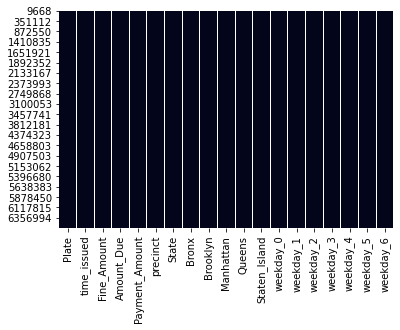

In [24]:
# Check for null values

sns.heatmap(violation_df.isnull(), cbar=False)

In [25]:
# View head before exporting as csv

violation_df.head()

,Plate,time_issued,Fine_Amount,Amount_Due,Payment_Amount,precinct,State,Bronx,Brooklyn,Manhattan,Queens,Staten_Island,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
9668,KYM0585,2019-12-31 10:26:00,45.0,75.0,75.0,63.0,0,0,1,0,0,0,0,1,0,0,0,0,0
9669,3247071,2019-12-31 10:22:00,45.0,55.0,55.0,63.0,0,0,1,0,0,0,0,1,0,0,0,0,0
9670,2FWQ91,2019-12-31 10:15:00,45.0,55.0,55.0,63.0,0,0,1,0,0,0,0,1,0,0,0,0,0
9671,JDP9488,2019-12-31 10:05:00,45.0,75.0,75.0,63.0,1,0,1,0,0,0,0,1,0,0,0,0,0
9672,5TM825,2019-12-31 09:59:00,45.0,75.0,75.0,63.0,0,0,1,0,0,0,0,1,0,0,0,0,0


In [26]:
# Export data

violation_df.to_csv('Tickets_Data.csv')